In [ ]:
!pip install transformers datasets accelerate peft
!pip install bitsandbytes


In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of PhiForSequenceClassification were not initialized from the model checkpoint at microsoft/phi-2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

<ipython-input-4-ffc6b853889d>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args, tokenizer=tokenizer)



LIAR — Best Threshold based on F1:
Threshold    0.750000
Precision    0.412602
Recall       0.904232
F1           0.566643
Accuracy     0.509866
Name: 13, dtype: float64


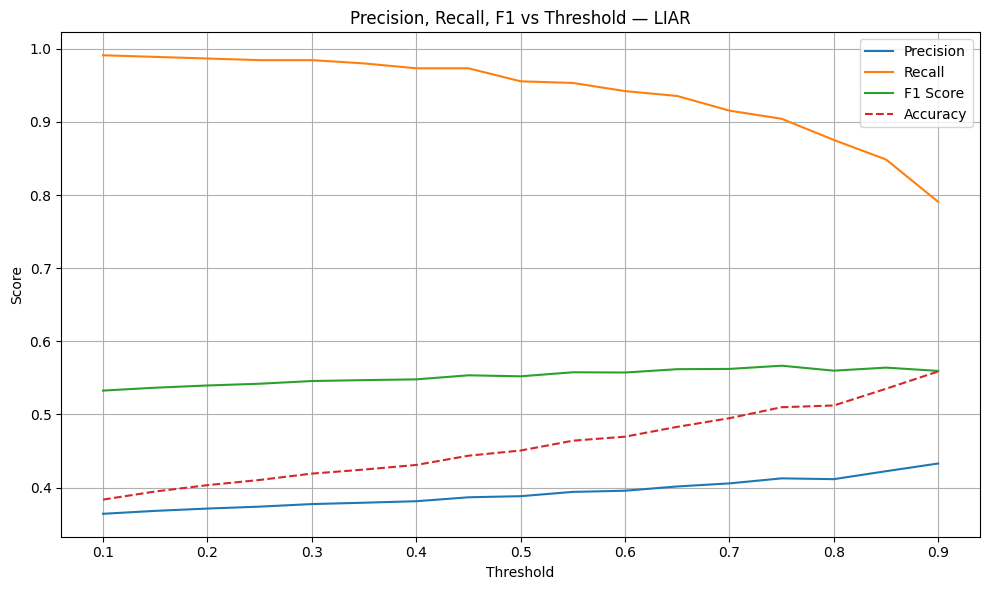

LIAR AUROC: 0.6429


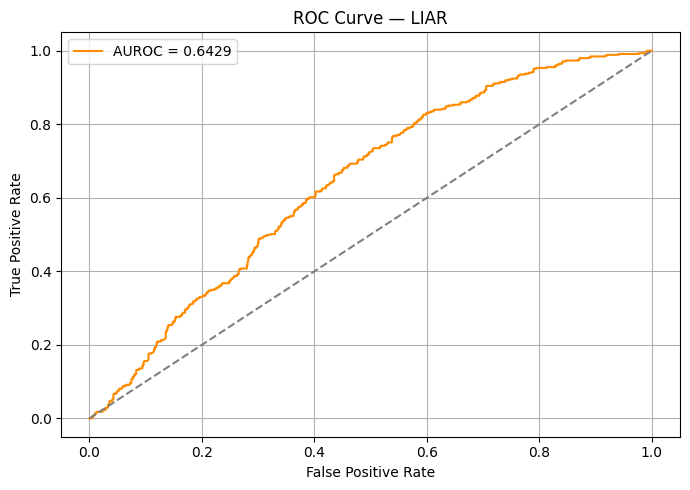

<Figure size 600x500 with 0 Axes>

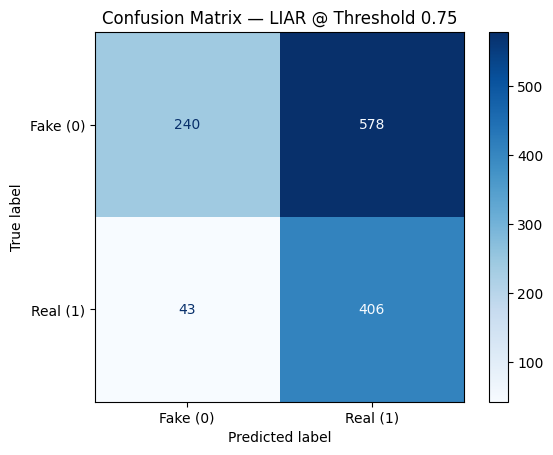

Predictions saved to liar_phi2_predictions.csv


Map:   0%|          | 0/85 [00:00<?, ? examples/s]

<ipython-input-4-ffc6b853889d>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args, tokenizer=tokenizer)



FakeNewsNet — Best Threshold based on F1:
Threshold    0.700000
Precision    0.615385
Recall       0.952381
F1           0.747664
Accuracy     0.682353
Name: 12, dtype: float64


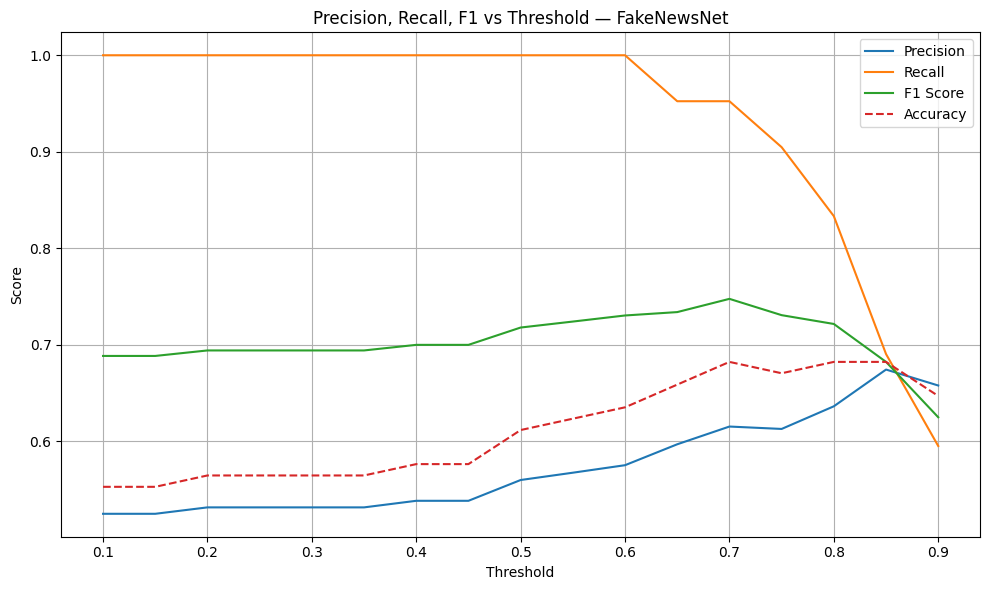

FakeNewsNet AUROC: 0.7273


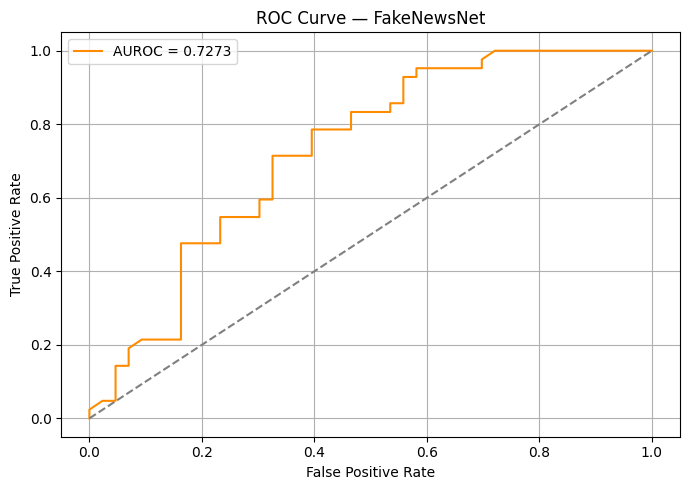

<Figure size 600x500 with 0 Axes>

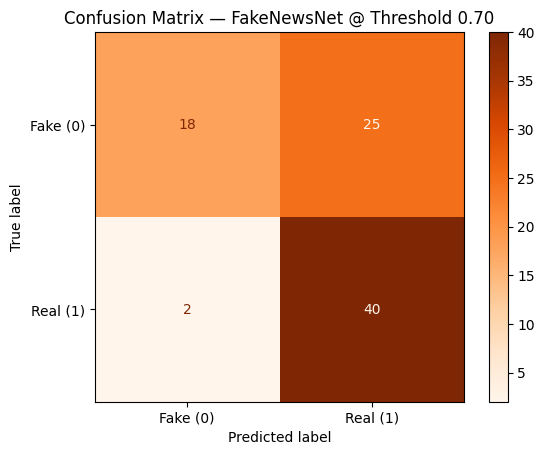

Predictions saved to fakenewsnet_phi2_predictions.csv


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    BitsAndBytesConfig
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)

os.environ["WANDB_DISABLED"] = "true"


model_path = "/content/drive/MyDrive/misinfo_project/models/phi2_it1"


tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16,
    num_labels=2
)
model.config.pad_token_id = tokenizer.pad_token_id
model.eval()

def evaluate_thresholds_and_roc(df_path, dataset_name):
    df = pd.read_csv(df_path).dropna(subset=["text", "label"])
    df["label"] = df["label"].astype(int)

    def tokenize(example):
        return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

    dataset = Dataset.from_pandas(df).map(tokenize, batched=True)
    dataset = dataset.remove_columns(["text"])
    dataset.set_format("torch")

    args = TrainingArguments(output_dir="./eval_temp", per_device_eval_batch_size=4, fp16=True, report_to="none")
    trainer = Trainer(model=model, args=args, tokenizer=tokenizer)
    predictions = trainer.predict(dataset)

    logits = torch.tensor(predictions.predictions)
    probs = torch.softmax(logits, dim=1)[:, 1].numpy()
    labels = predictions.label_ids

    thresholds = np.arange(0.1, 0.95, 0.05)
    metrics = []
    for t in thresholds:
        preds = (probs >= t).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
        acc = accuracy_score(labels, preds)
        metrics.append((t, precision, recall, f1, acc))

    df_metrics = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1", "Accuracy"])
    best = df_metrics.iloc[df_metrics["F1"].idxmax()]

    print(f"\n{dataset_name} — Best Threshold based on F1:")
    print(best)

    # Plot Precision/Recall/F1/Accuracy vs Threshold
    plt.figure(figsize=(10, 6))
    plt.plot(df_metrics["Threshold"], df_metrics["Precision"], label="Precision")
    plt.plot(df_metrics["Threshold"], df_metrics["Recall"], label="Recall")
    plt.plot(df_metrics["Threshold"], df_metrics["F1"], label="F1 Score")
    plt.plot(df_metrics["Threshold"], df_metrics["Accuracy"], label="Accuracy", linestyle="--")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision, Recall, F1 vs Threshold — {dataset_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    auroc = roc_auc_score(labels, probs)
    fpr, tpr, _ = roc_curve(labels, probs)

    print(f"{dataset_name} AUROC: {auroc:.4f}")
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"AUROC = {auroc:.4f}", color="darkorange")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {dataset_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    preds_best = (probs >= best["Threshold"]).astype(int)
    cm = confusion_matrix(labels, preds_best)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake (0)", "Real (1)"])
    cmap = "Blues" if dataset_name.lower() == "liar" else "Oranges"
    plt.figure(figsize=(6, 5))
    disp.plot(cmap=cmap, values_format="d")
    plt.title(f"Confusion Matrix — {dataset_name} @ Threshold {best['Threshold']:.2f}")
    plt.grid(False)
    plt.show()

    df_out = pd.DataFrame({
        "true_label": labels,
        "probability_real": probs,
        "predicted_label": preds_best
    })
    output_file = f"{dataset_name.lower()}_phi2_predictions.csv"
    df_out.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

evaluate_thresholds_and_roc("/content/drive/MyDrive/misinfo_project/liar/liar_test.csv", "LIAR")
evaluate_thresholds_and_roc("/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_test.csv", "FakeNewsNet")
